In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv(r'E:\A aPython Programms\Data1\Bank.csv')
df.head(5)

,Date,AXISBANK,AXISVOL,BAJAJFIN,BAJAJFINVOL,BOB,BOBVOL,FEDBANK,FEDVOL,HDFC,...,KOTAK,KOTAKVOL,PNB,PNBVOL,SBI,SBIVOL,REC,RECVOL,PIRAMAL,PIRAMALVOL
0,02-01-2009,108.379997,14261265,6.310420,141738,57.340000,1700495,16.889999,1359910,101.565002,...,97.900002,6258884,106.430000,2973855,133.184998,24161650,29.587500,9574565,134.700485,222908
1,05-01-2009,112.019997,9165605,6.504736,1120575,58.860001,2687100,17.129999,4379460,104.410004,...,99.637497,5956956,107.160004,3037185,136.080002,26931910,30.562500,8844514,136.025497,14449
2,06-01-2009,113.949997,12893855,6.660189,312830,57.750000,3162520,16.760000,1930260,110.040001,...,96.712502,9015300,106.089996,4110100,132.285004,35970960,29.831249,1078005,133.516418,102783
3,07-01-2009,104.419998,10571555,6.150109,166223,54.939999,5602350,16.459999,2251090,100.925003,...,90.762497,6482408,97.660004,6538860,124.004997,37268580,28.424999,5624090,131.853104,24863
4,09-01-2009,97.320000,25173105,6.048093,95905,54.689999,1806325,16.004999,4046570,101.750000,...,86.125000,5076276,97.129997,3834090,122.110001,24996510,28.818750,6157634,129.654144,301873


In [3]:
feature_columns = ['ICICI', 'ICICIVOL', 'SBI', 'FEDBANK', 'BAJAJFIN']
target_column = ['ICICI']
features = df[feature_columns]
target = df[target_column].shift(-3)

new_data1 = 1099.65
target.iloc[-3, 0] = new_data1

new_data2 = 1081.20
target.iloc[-2, 0] = new_data2

new_data3 = 1077.20
target.iloc[-1, 0] = new_data3


target.tail(5)

,ICICI
3748,1083.750000
3749,1093.300049
3750,1099.650000
3751,1081.200000
3752,1077.200000


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))
target=target.dropna()

n_steps = 5  # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [5]:
model_lstm = load_model('model_lstm_icici3h_0.9693.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R2: 0.9693
MAPE: 0.0223
RMSE: 22.7742
RMSE_normalizeddata: 0.0217
MAE_normalizeddata: 0.0173
MAE: 18.1993


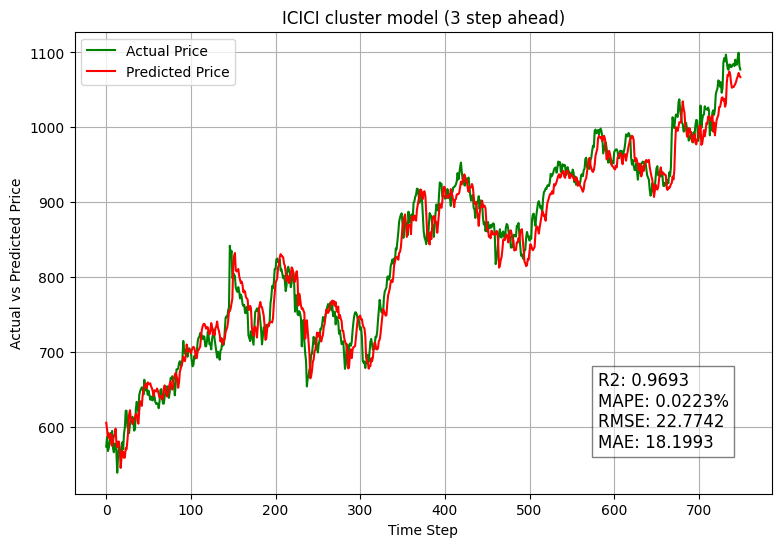

In [6]:
plt.figure(figsize=(9, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.75, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.grid(True)
plt.title('ICICI cluster model (3 step ahead)')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('ICICIcluster_3sa-1l.png', dpi=600)  # Saves the plot as a PNG file
plt.show()

In [7]:
model_lstm.predict(X_train)

predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.9868
MAPE: 0.0359
RMSE: 12.3395
RMSE_normalizeddata: 0.0117
MAE_normalizeddata: 0.0082
MAE: 8.6024


In [91]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6952e-04 - val_loss: 7.6514e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0027e-04 - val_loss: 8.1446e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2898e-04 - val_loss: 6.6767e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0167e-04 - val_loss: 0.0012
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9232e-04 - val_loss: 7.0259e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1169e-04 - val_loss: 6.5880e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0367e-04 - val_loss: 0.0013
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.7876e-04 - val_loss: 0.0012
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8568e-04 - val_loss: 0.0013
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7679e-04 

In [92]:
model_lstm.save(f"model_lstm_icici3h_{r2:.4f}.keras")

In [93]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0046 - val_loss: 9.9146e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1379e-04 - val_loss: 7.8680e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2949e-04 - val_loss: 9.9324e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8187e-04 - val_loss: 8.2817e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8920e-04 - val_loss: 6.7546e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1109e-04 - val_loss: 0.0011
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9277e-04 - val_loss: 5.6715e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9589e-04 - val_loss: 0.0012
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9597e-04 - val_loss: 0.0011
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9324e-04 - val_loss: 6.7572e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 

In [94]:
model_lstm.save(f"model_lstm_icici3h_{r2:.4f}.keras")

In [95]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.9058e-04 - val_loss: 0.0013
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.3365e-04 - val_loss: 9.8151e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.2096e-04 - val_loss: 8.8274e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.1415e-04 - val_loss: 5.7692e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.1365e-04 - val_loss: 0.0018
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8367e-04 - val_loss: 0.0011
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0430e-04 - val_loss: 7.9767e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8159e-04 - val_loss: 0.0012
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7686e-04 - val_loss: 5.2944e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 

In [96]:
model_lstm.save(f"model_lstm_icici3h_{r2:.4f}.keras")

In [97]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.7063e-04 - val_loss: 7.8214e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1743e-04 - val_loss: 9.0432e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4513e-04 - val_loss: 7.2193e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9998e-04 - val_loss: 0.0017
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8222e-04 - val_loss: 0.0017
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8143e-04 - val_loss: 0.0039
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7690e-04 - val_loss: 5.9282e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8370e-04 - val_loss: 6.4123e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7853e-04 - val_loss: 0.0012
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.

In [98]:
model_lstm.save(f"model_lstm_icici3h_{r2:.4f}.keras")

In [99]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0038 - val_loss: 9.6841e-04
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5224e-04 - val_loss: 7.9020e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1572e-04 - val_loss: 8.8978e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0894e-04 - val_loss: 0.0011
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1103e-04 - val_loss: 9.8093e-04
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0262e-04 - val_loss: 0.0022
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.2751e-04 - val_loss: 7.2717e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1148e-04 - val_loss: 6.5643e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8936e-04 - val_loss: 6.8851e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8371e-04 - val_loss: 0.0027
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step -

In [100]:
model_lstm.save(f"model_lstm_icici3h_{r2:.4f}.keras")

In [101]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9830e-04 - val_loss: 0.0014
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4774e-04 - val_loss: 0.0017
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2348e-04 - val_loss: 8.0899e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2169e-04 - val_loss: 0.0027
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2605e-04 - val_loss: 0.0012
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.7626e-04 - val_loss: 6.4163e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2034e-04 - val_loss: 6.3662e-04
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.0161e-04 - val_loss: 0.0011
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9866e-04 - val_loss: 0.0016
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.0039e-04

In [102]:
model_lstm.save(f"model_lstm_icici3h_{r2:.4f}.keras")

In [103]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.4927e-04 - val_loss: 7.6850e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2014e-04 - val_loss: 6.9017e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9494e-04 - val_loss: 0.0018
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8692e-04 - val_loss: 0.0023
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.9096e-04 - val_loss: 6.8984e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0269e-04 - val_loss: 0.0011
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6832e-04 - val_loss: 0.0028
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7335e-04 - val_loss: 7.3310e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7551e-04 - val_loss: 6.6630e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.72

In [104]:
model_lstm.save(f"model_lstm_icici3h_{r2:.4f}.keras")

In [105]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6454e-04 - val_loss: 0.0011
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4127e-04 - val_loss: 9.2073e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9700e-04 - val_loss: 9.0830e-04
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9569e-04 - val_loss: 0.0013
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8444e-04 - val_loss: 0.0013
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8573e-04 - val_loss: 6.3418e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1042e-04 - val_loss: 0.0012
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7343e-04 - val_loss: 7.5613e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7981e-04 - val_loss: 5.9731e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6590e-04

In [106]:
model_lstm.save(f"model_lstm_icici3h_{r2:.4f}.keras")

In [107]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6302e-04 - val_loss: 9.6882e-04
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9273e-04 - val_loss: 7.8388e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1100e-04 - val_loss: 0.0017
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9375e-04 - val_loss: 0.0016
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.9164e-04 - val_loss: 5.9079e-04
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.0603e-04 - val_loss: 6.0179e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.1477e-04 - val_loss: 0.0016
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6553e-04 - val_loss: 0.0012
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8345e-04 - val_loss: 6.4313e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 

In [108]:
model_lstm.save(f"model_lstm_icici3h_{r2:.4f}.keras")

In [109]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.3667e-04 - val_loss: 0.0057
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4292e-04 - val_loss: 7.3140e-04
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2134e-04 - val_loss: 0.0050
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4331e-04 - val_loss: 0.0011
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.7124e-04 - val_loss: 0.0022
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1192e-04 - val_loss: 7.7756e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6878e-04 - val_loss: 0.0026
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.8000e-04 - val_loss: 8.3046e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6884e-04 - val_loss: 6.3778e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.999

In [110]:
model_lstm.save(f"model_lstm_icici3h_{r2:.4f}.keras")